## Importing
     - importing libraries: pandas, numpy, matplotlib

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Preprocessing
     - converting the NA string values into NaN values
     - filtering the data and taking only the values of my home state
     - filling na values with mean values wherever the columns are numeric
     - removing outliers using z-score, setting the threshold to 3.5

In [18]:
predf = pd.read_csv('clustering_data.csv', low_memory=False)
predf['Latitude'] = pd.to_numeric(predf['Latitude'], errors='coerce')
predf['Longitude'] = pd.to_numeric(predf['Longitude'], errors='coerce')

df = predf[predf.iloc[:, 8] == 'TELANGANA'].copy()

numeric_cols = df[['Latitude', 'Longitude']]
for col in numeric_cols:
    mean_val = df[col].mean()
    df.loc[:, col] = df[col].fillna(mean_val)

df.dropna(subset='Pincode')
def findoutliers(column):
    median = column.median()
    mad = (column - median).abs().median()
    modzscore = 0.675 * (column - median) / mad
    outliers = column.index[modzscore.abs() >= 4].tolist()
    return outliers

col9_name = df.columns[9]
col10_name = df.columns[10]

for col in [col9_name, col10_name]:
    outliers = findoutliers(df[col])
    df.loc[outliers, col] = np.nan

df.dropna(subset=[col9_name, col10_name], inplace=True)
print(df.head)

<bound method NDFrame.head of               CircleName             RegionName        DivisionName  \
138     Telangana Circle       Hyderabad Region  Nizamabad Division   
139     Telangana Circle       Hyderabad Region  Nizamabad Division   
140     Telangana Circle       Hyderabad Region  Nizamabad Division   
141     Telangana Circle       Hyderabad Region  Nizamabad Division   
142     Telangana Circle       Hyderabad Region  Nizamabad Division   
...                  ...                    ...                 ...   
150614  Telangana Circle       Hyderabad Region   Nalgonda Division   
151046  Telangana Circle  Hyderabad City Region      Medak Division   
151047  Telangana Circle  Hyderabad City Region      Medak Division   
151048  Telangana Circle  Hyderabad City Region      Medak Division   
151049  Telangana Circle  Hyderabad City Region      Medak Division   

               OfficeName  Pincode OfficeType  Delivery             District  \
138         Arsapalli B.O   503186   

## Plotting the data using a scatter plot
     - making columns latittudes and longitudes
     - plotting them on a scatter plot to visualise the pin code distribution across my home state

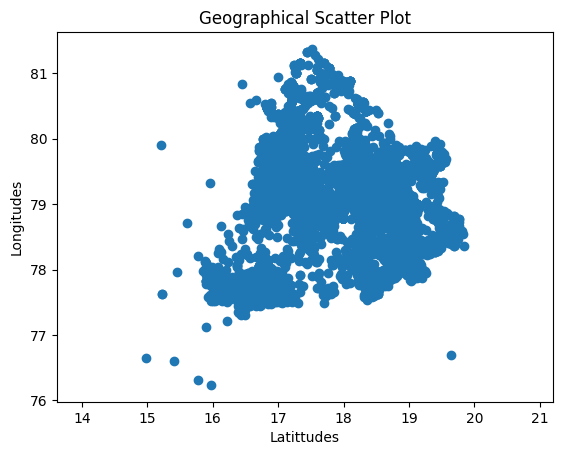

In [19]:
latitudes = df.iloc[:, 9]
longitudes = df.iloc[:, 10]

plt.scatter(latitudes, longitudes, marker='o')
plt.xlabel("Latittudes")
plt.ylabel("Longitudes")
plt.title("Geographical Scatter Plot")
plt.axis("equal")
plt.show()

## Defining a Function to find Euclidean Distance

In [20]:
def euclideandist(point, centroids):
    return np.sqrt(np.sum((centroids-point)**2, axis= 1))

## Implementing K-Means CLustering
     - defining a metric called wcss for later use
     - defining a method called fit
          - inside fit, we first initialise centroids randomly, we will keep updating these centroids
          - then we iterate until maximum iterations
          - in each iteration we iterate through the data points, calculate their distances from all the centroids, and assign it to the closest one, we make an array called y which contains the cluster number for every data point
          - then we make an array called cluster indices which is an array of arrays containing the index of the data pont in x train which belongs to the cluster
          - now we make an array called cluster centers and assign it to the mean point in every cluster
          - and add a break if the cluster centers dont change anymore
          - now for this given clustering, calculate the wcss score
          - in the fit method, return y which is the clustering result and the wcss score

In [21]:
class kmeansclustering:
    def __init__(self, k = 3):
        self.k = k
        self.centroids = None

    def wcss(self, centroid, datapointsarray):
        return np.sum(datapointsarray-centroid)**2
    
    def fit(self, xtrain, maxiterations = 200):
        # first you initialse random centroids
        self.centroids = np.random.uniform(np.amin(xtrain,axis=0), np.amax(xtrain,axis=0), size=(self.k,xtrain.shape[1]))
        # created a numpy array of shape = (k,dimension) representing k centroids
        for iteration in range(maxiterations):
            y = []

            for datapoint in xtrain:
                distances = euclideandist(datapoint, self.centroids)
                cluster = np.argmin(distances)
                y.append(cluster)
            y = np.array(y)
            # so what we did until now is assign the clusters based on randomly chosen 
            # y holds the cluster index for each data point

            clusterindices = []
            for i in range(self.k):
                indices = np.where(y == i)[0]
                clusterindices.append(indices)
            # here we're trying to find out in y(the array of all the points), which indices belong to which cluster
            # so what clusterindices holds is a list of lists
            # each list for all the data points in one cluster

            clustercenters = []
            # an array of new cluster centers in each iteration

            for i, indices in enumerate(clusterindices):
                if len(indices) == 0:
                    clustercenters.append(np.random.uniform(np.amin(xtrain, axis=0), np.amax(xtrain, axis=0)))
                # some clusters might be empty, in that case the centroid wont change
                else:
                    mean = np.mean(xtrain[indices], axis=0)
                    clustercenters.append(mean)
                # if the cluster isnt empty then add the mean of all the data points in that cluster to the clustercenters list
            
            if np.max(np.array(self.centroids) - np.array(clustercenters)) <= np.array(0.00001):
                break
            # breaking the iterations if there is no change in centroids anymore
            else:
                self.centroids = np.array(clustercenters)
            # if the centroids do change, then updating self.centroids
            
        wcssscore = 0
        for i in range(self.k):
            indices = np.where(y == i)[0]
            # if len(indices) > 0:
            cluster_points = xtrain[indices]
            wcssscore += np.sum((cluster_points - self.centroids[i])**2)

        return y, wcssscore

## Finding the Ideal K
     - to find the ideal k set a range of what k can be
     - initialise and populate an array called wcss scores by iterating through k values and calling the fit method
     - find the differences and the differences of the differences i.e. acceleration
     - find the k which has the biggest difference in the acceleration
     - plot this wcss vs k as a scatter plot
     - find the elbow point and set that as idealk

Optimal K Value =  6


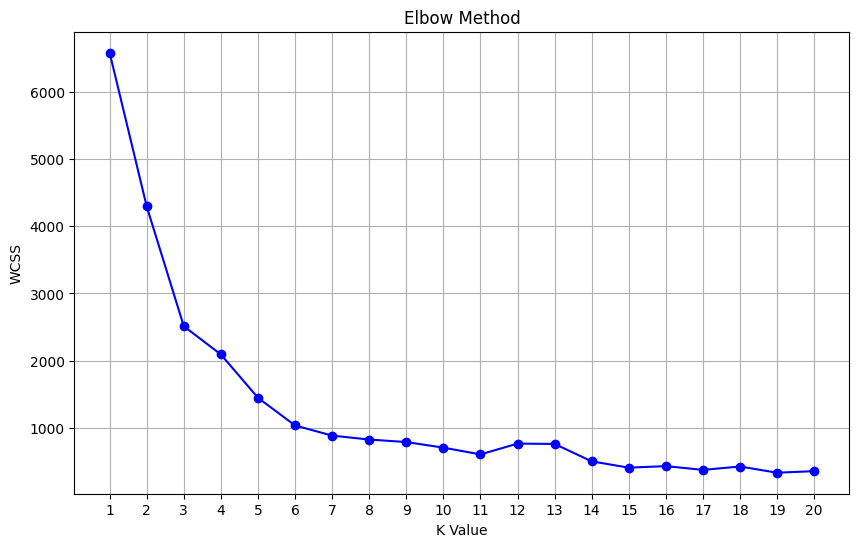

In [22]:
dataset = np.array(list(zip(latitudes, longitudes)))
kvalues = np.arange(1,21)
wcssvals = []
for ktemp in kvalues:
    model = kmeansclustering(k=ktemp)
    _, wcss = model.fit(xtrain=dataset, maxiterations=200)
    wcssvals.append(wcss)

slope = (wcssvals[-1]-wcssvals[0])/(kvalues[-1]-kvalues[0])
intercept = wcssvals[0]-slope*kvalues[0]

distances = []
for i in range(len(kvalues)):
    num = np.abs(slope * kvalues[i] - wcssvals[i] + intercept)
    den = np.sqrt(slope**2 + 1)
    distances.append(num/den)

idealk = np.argmax(distances) + 1
print("Optimal K Value = ", idealk)


plt.figure(figsize=(10, 6))
plt.plot(kvalues, wcssvals, 'bo-')
plt.xlabel('K Value')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.xticks(kvalues)
plt.grid(True)
plt.show()

## Setting the Model to K-Means Clustering 
     - assign ypred as an array and cluster

In [25]:
model = kmeansclustering(k = idealk)
ypred, _ = model.fit(dataset, maxiterations=200)

## Plotting the Points with CLustering and Colour Coding them

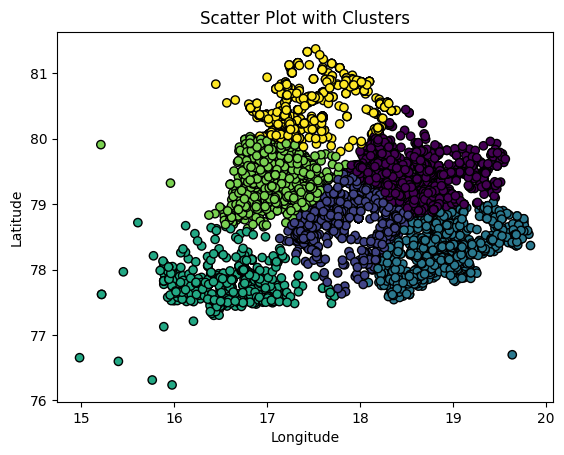

In [26]:
plt.scatter(dataset[:, 0], dataset[:, 1], c=ypred, cmap='viridis', edgecolors='black')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter Plot with Clusters")
plt.show()

## Drawing Inferences Based on my Clustering
     - All clusters have a high density of points, indicating that the regions are highly populated. There are a few outliers, but most points are tightly packed within their clusters.
     - It could be used for regional analysis like resource allocation and things that need identification of geographical zones for targeted services and understanding of spatial distribution patterns within the dataset.